# W207 Final Project
## Recommender Systems
### Erin Werner, Dhileeban Kumaresan, Jocelyn Lu

#### Step 1: Import Packages

In [1]:
import numpy as np
import urllib
import scipy.optimize
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import Counter
import statistics
from operator import itemgetter
import json
from sklearn.metrics import mean_squared_error
from sklearn import svm
import math
from scipy.sparse.linalg import svds
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import networkx as nx
from sklearn.metrics import mean_squared_error
from math import sqrt
from networkx.algorithms import bipartite
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
from sklearn import datasets
from mlxtend.plotting import plot_decision_regions

#### Step 2: Download Dataset

In [2]:
my_test = pd.read_csv("/Users/erinwerner/Downloads/18_2157_bundle_archive/Reviews.csv")

In [3]:
my_test[0:5]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
len(my_test)

568454

#### Step 3: Data Exploration

In [5]:
my_test['PercentHelpful'] = (my_test['HelpfulnessNumerator']/my_test['HelpfulnessDenominator'])*100

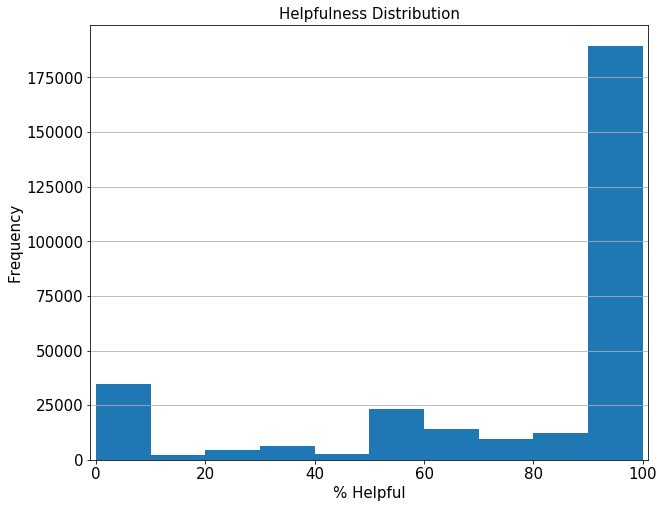

In [6]:
plt.figure(figsize=[10,8])

plt.hist(my_test['PercentHelpful'].dropna().values, bins = [0,10,20,30,40,50,60,70,80,90,100])

plt.xlim(-1, 101)
plt.grid(axis='y')
plt.xlabel('% Helpful',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Helpfulness Distribution',fontsize=15)
plt.show()

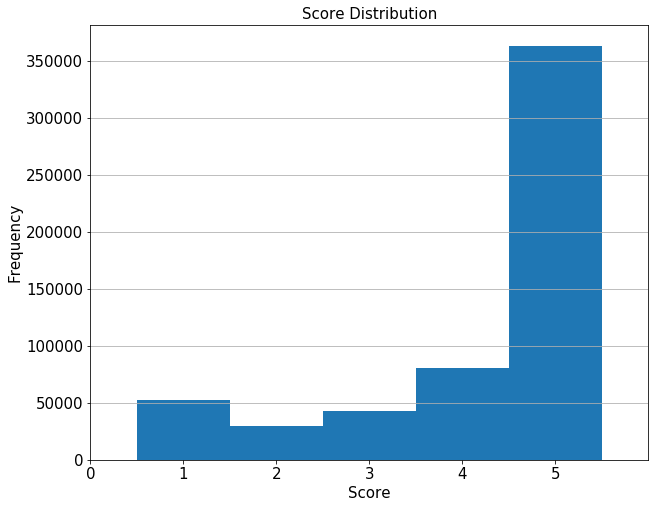

In [7]:
plt.figure(figsize=[10,8])
bins = np.arange(7) - 0.5

plt.hist(my_test['Score'], bins)

plt.xlim(0, 6)
plt.grid(axis='y')
plt.xlabel('Score',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(range(6), fontsize=15)
plt.yticks(fontsize=15)
plt.title('Score Distribution',fontsize=15)
plt.show()

#### Step 4: Network Visualizations

In [8]:
userScores = defaultdict(list)
productScores = defaultdict(list)
userProducts = defaultdict(list)
productUsers = defaultdict(list)

product,user,score = my_test['ProductId'],my_test['UserId'],my_test['Score']

for i in range(0,len(my_test)):
    userScores[user[i]].append(score[i])
    productScores[product[i]].append(score[i])
    userProducts[user[i]].append(product[i])
    productUsers[product[i]].append(user[i])

Because our data set is so large, we will take a look at the networks for the users and products with some of the most reviews. This will help us to gain some high-level insight to the structure of our data.

##### Product Network

First, we will look at the product-to-product network. This means that every node is a product and every edge represents a user that has reviewed that product.

In [9]:
top_products = my_test['ProductId'].value_counts()[:10]
top_products = top_products.index.tolist()
top_products

['B007JFMH8M',
 'B002QWP8H0',
 'B002QWHJOU',
 'B0026RQTGE',
 'B002QWP89S',
 'B003B3OOPA',
 'B001EO5Q64',
 'B0026KPDG8',
 'B001RVFEP2',
 'B006HYLW32']

In [10]:
from_list = []
to_list = []

for my_prod in top_products:
#for k,v in productUsers.items():               
    #print("%s - %s" % (str(k), str(v)))
    #my_from = k
    my_from = my_prod
    #my_users = v
    my_users = productUsers[my_prod]
    
    for user in my_users:
        my_tos = userProducts[user]
        
        for my_to in my_tos:
            from_list.append(my_from)
            to_list.append(my_to)

In [11]:
len(from_list)

50450

In [12]:
len(to_list)

50450

In [13]:
#from_list = []
#to_list = []

#for k,v in productUsers.items():               
#    #print("%s - %s" % (str(k), str(v)))
#    my_from = k
#    my_users = v
    
#    for user in my_users:
#        my_tos = userProducts[user]
        
#        if len(my_tos) > 200:
#            for my_to in my_tos:
#                if my_from != my_to:
#                    from_list.append(my_from)
#                    to_list.append(my_to)

In [14]:
#len(from_list)

In [13]:
prod_df = pd.DataFrame({ 'from':from_list, 'to':to_list})
prod_df.head()

,from,to
0,B007JFMH8M,B007JFMH8M
1,B007JFMH8M,B002TMV3E4
2,B007JFMH8M,B002TMV34E
3,B007JFMH8M,B004ZIER34
4,B007JFMH8M,B004CYLW7A


/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


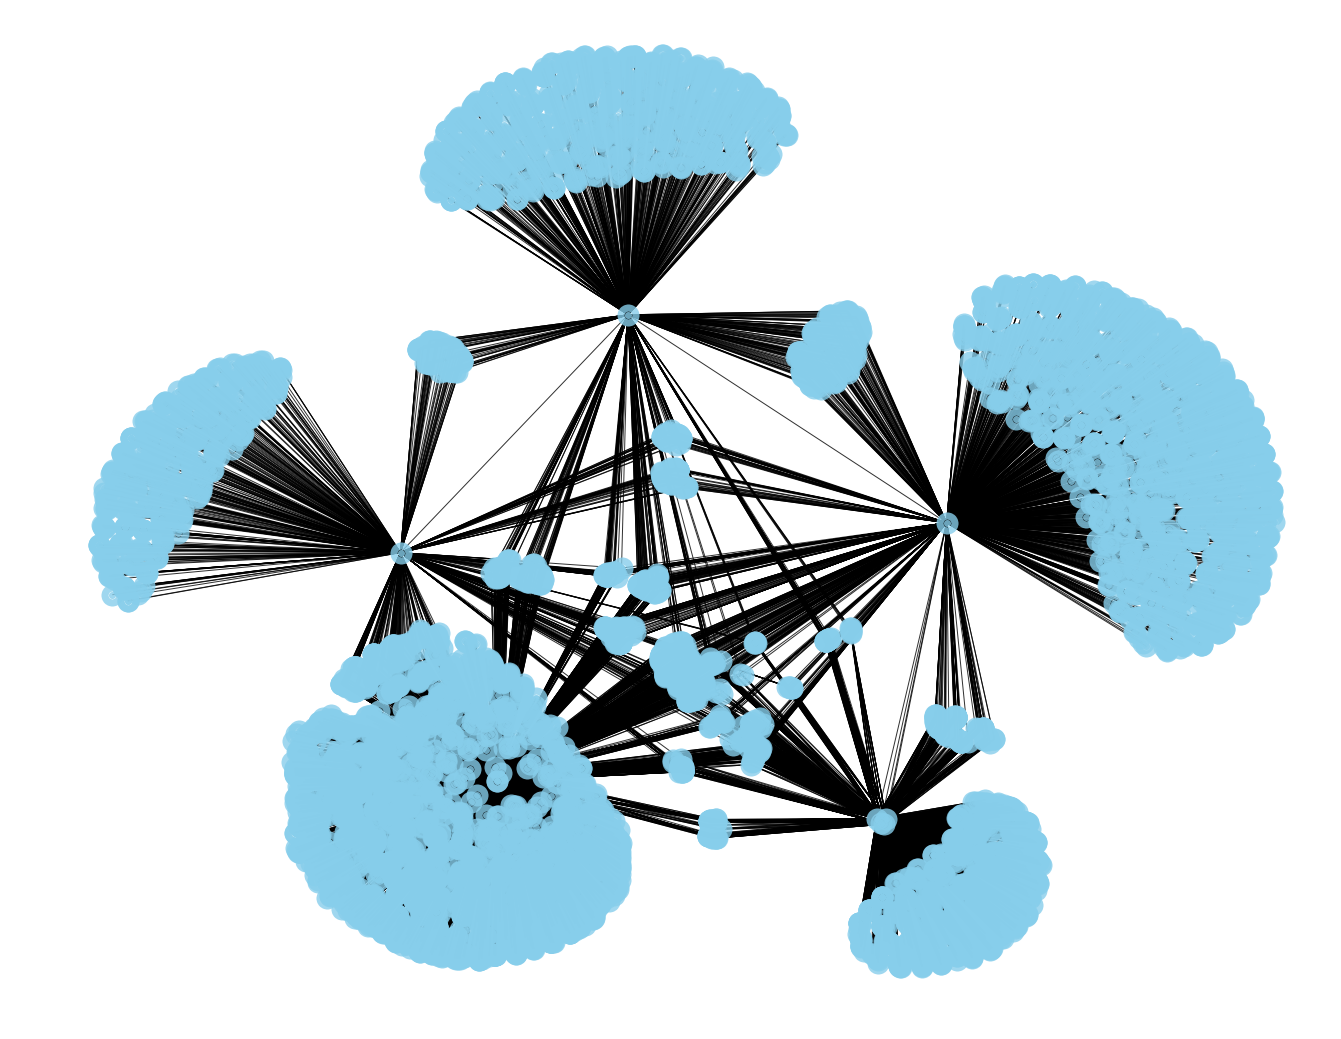

In [14]:
%matplotlib inline

plt.figure(figsize=(18,14))

# Build your graph
G=nx.from_pandas_edgelist(prod_df, 'from', 'to')

# Graph with Custom nodes:
nx.draw(G, 
        #with_labels=True, 
        node_size=50, 
        node_color="skyblue", 
        node_shape="o", 
        alpha=0.8, 
        linewidths=15)
plt.show()


We can see some clear clustering, indicating at similarity between items.

##### User Network

Next, we will look at the user-to-user network. This means that every node is a user and every edge represents a product that has been reviewed by that user.

In [14]:
top_users = my_test['UserId'].value_counts()[:10]
top_users = top_users.index.tolist()
top_users

['A3OXHLG6DIBRW8',
 'A1YUL9PCJR3JTY',
 'AY12DBB0U420B',
 'A281NPSIMI1C2R',
 'A1Z54EM24Y40LL',
 'A1TMAVN4CEM8U8',
 'A2MUGFV2TDQ47K',
 'A3TVZM3ZIXG8YW',
 'A3PJZ8TU8FDQ1K',
 'AQQLWCMRNDFGI']

In [15]:
from_list = []
to_list = []

for my_user in top_users:
#for k,v in productUsers.items():               
    #print("%s - %s" % (str(k), str(v)))
    #my_from = k
    my_from = my_user
    #my_users = v
    my_products = userProducts[my_user]
    
    for prod in my_products:
        my_tos = productUsers[prod]
        
        for my_to in my_tos:
            from_list.append(my_from)
            to_list.append(my_to)

In [16]:
#from_list = []
#to_list = []

#for k,v in userProducts.items():               
#    #print("%s - %s" % (str(k), str(v)))
#    my_from = k
#    my_products = v
    
#    for prod in my_products:
#        my_tos = productUsers[prod]
        
#        if len(my_tos) > 800:
#            for my_to in my_tos:
#                if my_from != my_to:
#                    from_list.append(my_from)
#                    to_list.append(my_to)

In [17]:
len(from_list)

187144

In [18]:
user_df = pd.DataFrame({ 'from':from_list, 'to':to_list})
user_df.head()

,from,to
0,A3OXHLG6DIBRW8,A1OIMIM4FHT4IG
1,A3OXHLG6DIBRW8,A3OXHLG6DIBRW8
2,A3OXHLG6DIBRW8,A2TJG4N8LNJW23
3,A3OXHLG6DIBRW8,A2129VQGGHR150
4,A3OXHLG6DIBRW8,A1HQV09XG1Z0YW


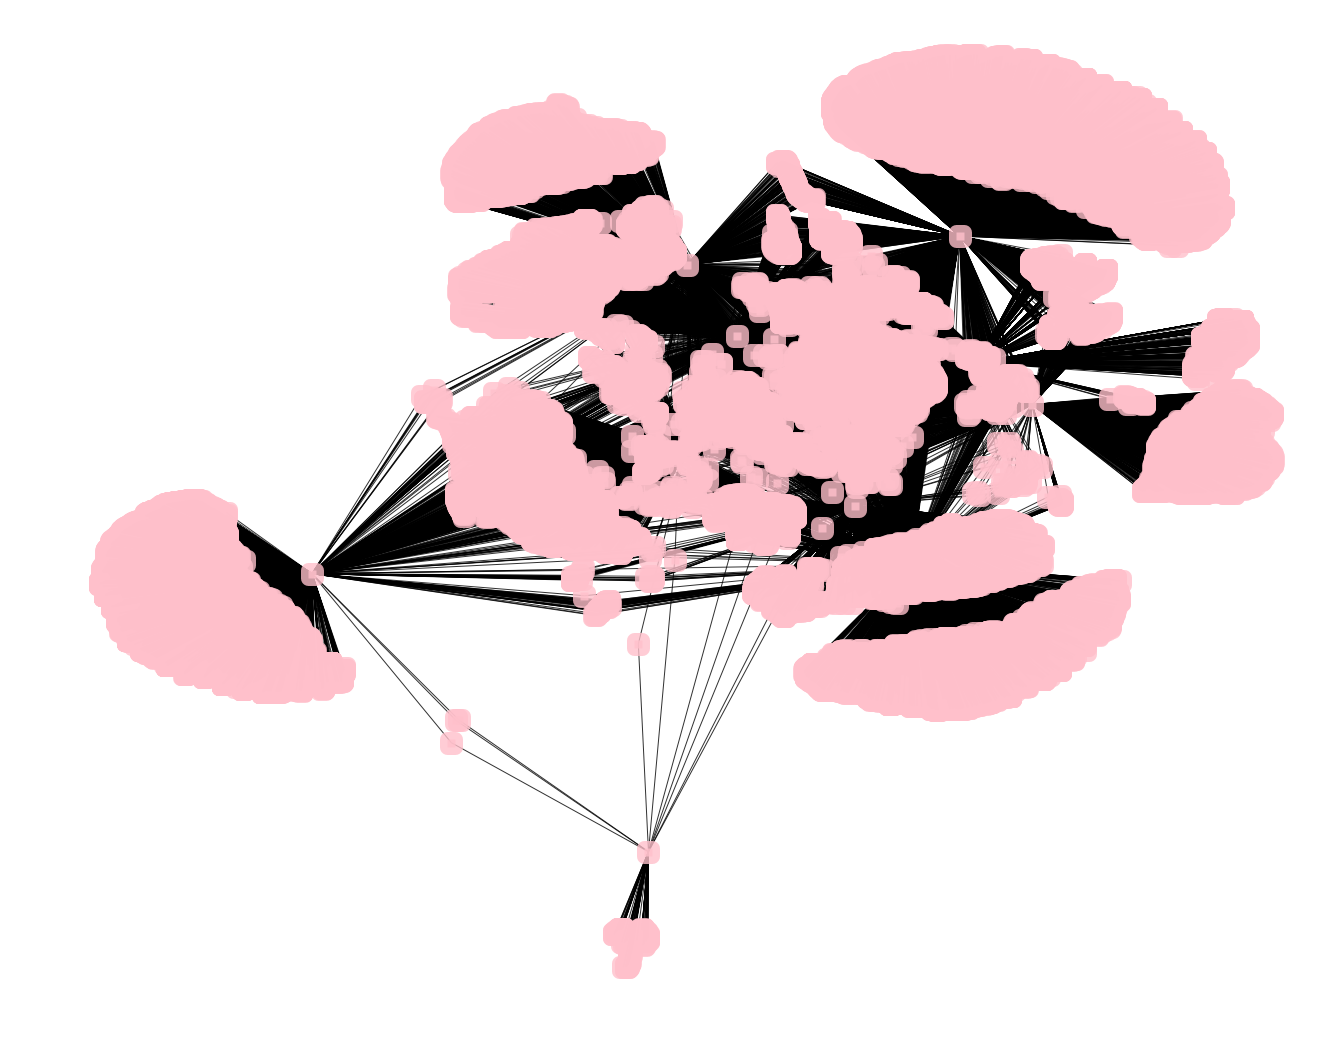

In [19]:
%matplotlib inline

plt.figure(figsize=(18,14))

# Build your graph
G=nx.from_pandas_edgelist(user_df, 'from', 'to')

# Graph with Custom nodes:
nx.draw(G, 
        #with_labels=True, 
        node_size=50, 
        node_color="pink", 
        node_shape="s", 
        alpha=0.8, 
        linewidths=15)
plt.show()


Once again, we can see some clear clustering, indicating at similarity between users.

##### Product-User Network

Last, we will look at the user-to-product network. This means that each node is a product or user (deliminated by color). Each edge represents a review between the user node and the product node.

In [19]:
top_users = my_test['UserId'].value_counts()[:25]
top_users = top_users.index.tolist()

top_products = my_test['ProductId'].value_counts()[:25]
top_products = top_products.index.tolist()

In [20]:
from_list = []
to_list = []

for my_user in top_users:
    my_from = my_user
    my_products = userProducts[my_user]
    
    for prod in my_products:
        my_to = prod
        from_list.append(my_from)
        to_list.append(my_to)
        
for my_prod in top_products:
    my_from = my_prod
    my_users = productUsers[my_prod]
    
    for user in my_users:
        my_to = user
        from_list.append(my_from)
        to_list.append(my_to)

In [21]:
len(from_list)

19801

In [22]:
top_prod_user_df = pd.DataFrame({ 'from':from_list, 'to':to_list})
top_prod_user_df.head()

,from,to
0,A3OXHLG6DIBRW8,B002O3VHXU
1,A3OXHLG6DIBRW8,B004ET7MG8
2,A3OXHLG6DIBRW8,B005K4Q1VI
3,A3OXHLG6DIBRW8,B005K4Q1VI
4,A3OXHLG6DIBRW8,B000VSDFRG


In [23]:
# Build your graph
G=nx.from_pandas_edgelist(top_prod_user_df, 'from', 'to')

color_map = []
for node in G:
    if node[0] == 'A':
        color_map.append('pink')
    else: 
        color_map.append('skyblue')      


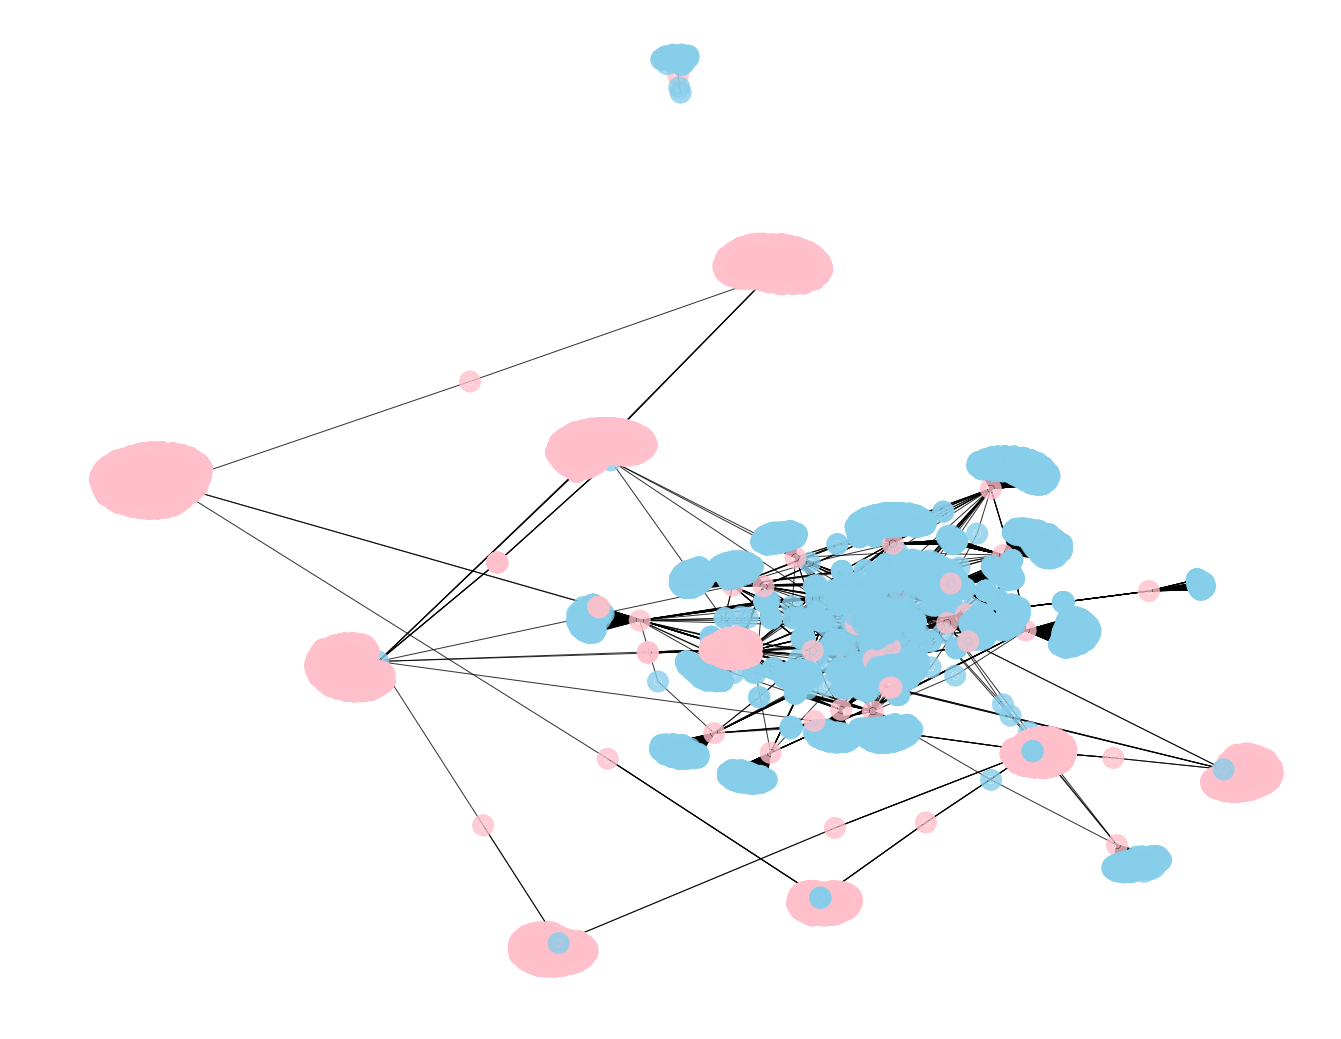

In [25]:
%matplotlib inline

plt.figure(figsize=(18,14))

# Graph with Custom nodes:
nx.draw(G, 
        #with_labels=True, 
        node_size=50, 
        node_color=color_map, 
        #node_shape="s", 
        alpha=0.8, 
        linewidths=15)
plt.show()


We have a very interconnected network. Although there is some clustering amongst some products and users, it is common to see one product with many users and vice versa. But, this could be a result of looking at just the most popular products and users in order to subset the data.

#### Step 5: Collaborative Filtering 

Collaborative filtering is a family of algorithms where there are multiple ways to find similar users or items and multiple ways to calculate rating based on ratings of similar users. Similarity is calculated only on the basis of the rating a user gives to an item.

Collaborative filtering works around the interactions that users have with items. These interactions can help find patterns in the data that reveal information about the items or users. Collaborative filtering doesn’t require features about the items or users to be known and it is suited for a set of different types of items. Furthermore, collaborative filtering can help recommenders to not overspecialize in a user’s profile and recommend items that are completely different from what they have seen before.

#### Step 5.1: Collaborative Filtering & Pearson Correlation

Collaborative Filtering is the most common technique used when it comes to building intelligent recommender systems that can learn to give better recommendations as more information about users is collected.

This technique is used to build recommenders that give suggestions to a user on the basis of the likes and dislikes of similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

First, we will subset the data into training and test.

In [9]:
X = my_test[['ProductId', 'UserId', 'ProfileName']]
y = my_test['Score']

In [20]:
#very small subset because my computer is old and cant handle much more :(

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.98, random_state=42)

We can check to see if the distribution of 'Scores' still reflects the overall dataset.

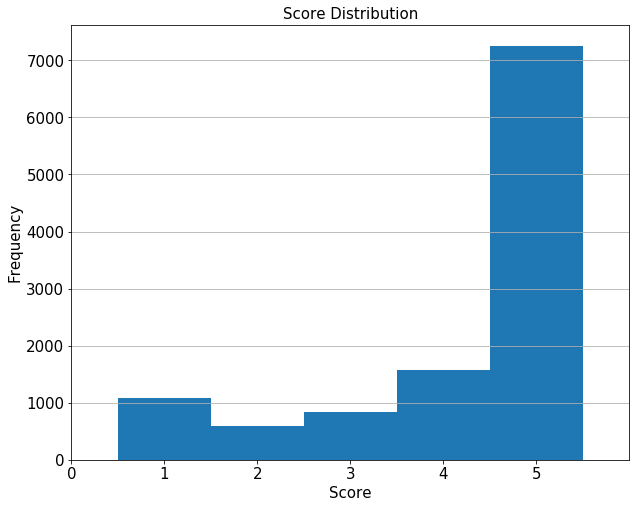

In [21]:
plt.figure(figsize=[10,8])
bins = np.arange(7) - 0.5

plt.hist(y_train, bins)

plt.xlim(0, 6)
plt.grid(axis='y')
plt.xlabel('Score',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(range(6), fontsize=15)
plt.yticks(fontsize=15)
plt.title('Score Distribution',fontsize=15)
plt.show()

To utilize recommendation algorithms, you’ll need data that contains a set of items and a set of users who have reacted to some of the items. In this context, we have a set of products, a set of users, and reviews of the products by users.

In [22]:
#get unique users and products
unq_prod = X_train.ProductId.unique() 
unq_user = X_train.UserId.unique() 

In [23]:
len(unq_prod)

7289

In [24]:
len(unq_user)

10505

However, it is possible that some users could be considered absolutely similar with the Pearson metric despite having different ratings. Some users might be consistantly tough raters, where others are consistantly generous. An example would be a food critic who always gives out ratings lower than the average, but the rankings of the items in their list would be similar to the normal raters.

To factor in such individual user preferences, you will need to bring all users to the same level by removing their biases. You can do this by subtracting the average rating given by that user to all items from each item rated by that user. This can also be done for products.

In [25]:
y_copy = y_train.tolist()
userId_copy = X_train.UserId.tolist()
prodId_copy = X_train.ProductId.tolist()

In [26]:
user_averages = []

for u in unq_user:
    my_indexes = [index for index, value in enumerate(userId_copy) if value == u]
    all_ratings = []
    
    for i in my_indexes:
        my_rating = y_copy[i]
        all_ratings.append(my_rating)
    
    user_avg_rate = np.mean(all_ratings)
    user_averages.append(user_avg_rate)

In [27]:
prod_averages = []

for p in unq_prod:
    my_indexes = [index for index, value in enumerate(prodId_copy) if value == p]
    all_ratings = []
    
    for i in my_indexes:
        my_rating = y_copy[i]
        all_ratings.append(my_rating)
    
    prod_avg_rate = np.mean(all_ratings)
    prod_averages.append(prod_avg_rate)

By doing this, we have changed the value of the average rating given by every user or to every product to 0, which brings them all to the same level and removes their biases.

###### Pearson Correlation - Similar Users

The technique where the rating matrix is used to find similar users based on the ratings they give, is called user-based or user-user collaborative filtering. 

* User-based: For a user U, with a set of similar users determined based on rating vectors consisting of given item ratings, the rating for an item I, which hasn’t been rated, is found by picking out N users from the similarity list who have rated the item I and calculating the rating based on these N ratings.

In most cases, the cells in the matrix are empty, as users only rate a few items. It’s highly unlikely for every user to rate or react to every item available. This then produces a matrix with mostly empty cells, which is classified as sparse.

So, our next step will be to create the sparse score matrix. 

* Rows : Products
* Columns : Users

This will help us to determine similar users.

This matrix will consist of the reactions given to a set of items by some users from a set of users. Each row will contain the ratings received by an item, and each column will contain the ratings given by a user.

In [28]:
prod_user_matrix = []
prod_count = 0

for p in unq_prod:
    my_row = []
    my_curr_prod_users = productUsers[p]
    avg_prod_rating = prod_averages[prod_count]
    
    for u in unq_user:
        if u in my_curr_prod_users:
            sub_prod = my_test[my_test['ProductId'] == p] 
            orig_row = sub_prod[sub_prod['UserId'] == u]
            
            if len(orig_row) > 1:
                my_rating = orig_row['Score'].mean() - avg_prod_rating
            else:
                my_rating = orig_row['Score'].item() - avg_prod_rating
                
            if my_rating == 0.0:
                my_rating += 0.01
                
        else:
            my_rating = None
            
        my_row.append(my_rating)
    
    prod_user_matrix.append(my_row)
    prod_count += 1
    
     

In [29]:
len(prod_user_matrix)

7289

In [30]:
prod_user_df = pd.DataFrame(prod_user_matrix)

In [31]:
prod_user_df.head()

,0,1,2,3,4,5,6,7,8,9,...,10495,10496,10497,10498,10499,10500,10501,10502,10503,10504
0,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# calculate Pearson's correlation
pu_df = prod_user_df.fillna(0)
matrix_corr_p = pu_df.corr(method='pearson')
matrix_corr_p.head()

,0,1,2,3,4,5,6,7,8,9,...,10495,10496,10497,10498,10499,10500,10501,10502,10503,10504
0,1.000000,-0.000309,-0.000377,-0.000350,0.000255,-0.000269,-0.000269,-0.000269,-0.000325,-0.000269,...,-0.000088,-0.000269,-0.000269,-0.000270,-0.000279,-0.000269,-0.000363,-0.000269,-0.000820,-0.000366
1,-0.000309,1.000000,-0.000221,-0.000206,0.000150,-0.000158,-0.000158,-0.000158,-0.000191,-0.000158,...,-0.000052,-0.000158,-0.000158,-0.000158,-0.000164,-0.000158,-0.000213,-0.000158,-0.000481,-0.000215
2,-0.000377,-0.000221,1.000000,-0.000251,0.000183,-0.000193,-0.000193,-0.000193,-0.000233,-0.000193,...,-0.000063,-0.000193,-0.000193,-0.000194,-0.000200,-0.000193,-0.000260,-0.000193,-0.000588,-0.000263
3,-0.000350,-0.000206,-0.000251,1.000000,0.000170,-0.000179,-0.000179,-0.000179,-0.000216,-0.000179,...,-0.000059,-0.000179,-0.000179,-0.000180,-0.000186,-0.000179,-0.000242,-0.000179,-0.000547,-0.000244
4,0.000255,0.000150,0.000183,0.000170,1.000000,0.000130,0.000130,0.000130,0.000157,0.000130,...,0.000043,0.000130,0.000130,0.000131,0.000135,0.000130,0.000176,0.000130,0.000398,0.000178


We can see a correlation of 1 all along the diagonal.

In [33]:
len(matrix_corr_p)

10505

In [34]:
prod_corr = pd.Series()

prod_id = 0

for user in prod_user_df.iloc[prod_id].dropna().index:
    corr_list = matrix_corr_p[user]*prod_user_df[user][prod_id]
    prod_corr = prod_corr.append(corr_list)

In [35]:
prod_corr = prod_corr.groupby(prod_corr.index).sum()

In [36]:
myuser_list = []

for i in range(0,len(prod_user_df.iloc[prod_id].dropna().index)):
    if prod_user_df.iloc[prod_id].dropna().index[i] in prod_corr:
        myuser_list.append(prod_user_df.iloc[prod_id].dropna().index[i])
    
prod_corr = prod_corr.drop(myuser_list)

In [37]:
print('Based on the users that reviewed, ', unq_prod[prod_id], '\n')

for i in prod_user_df.iloc[prod_id].dropna().index:
    #my_name = X_train.ProfileName[X_train['UserId'] == unq_user[i]].item()
    my_name_index = X_train.ProfileName[X_train['UserId'] == unq_user[i]].index[0]
    my_name = my_test.ProfileName.loc[my_name_index]
    print(unq_user[i], ': ', my_name)

print('\nsimilar users might be: \n')

for i in prod_corr.sort_values(ascending=False).index[:5]:
    #my_name = X_train.ProfileName[X_train['UserId'] == unq_user[i]].item()
    my_name_index = X_train.ProfileName[X_train['UserId'] == unq_user[i]].index[0]
    my_name = my_test.ProfileName.loc[my_name_index]
    print(unq_user[i], ': ', my_name)

Based on the users that reviewed,  B001J9QBU4 

A1O9HDGEU6T1LY :  Marly
A2FJH6TNED2M1P :  Jeffrey Upah
AQQLWCMRNDFGI :  Steven A. Peterson
A4VMQ6ZTSXSSL :  kiwanissandy "Go Bucks!"
A208ULV3V7OKBQ :  Annmarie
A1JVFV1VAA08X :  gregc4
A3PJZ8TU8FDQ1K :  Jared Castle
A2DR708CP7W57V :  Marguerite Buckley "Marguerite B"
AEVJIK8MCL9ZO :  John West "pianodave"
A386VGG59KAT3F :  sbs102010
A1DBF19L6Y5AKO :  RobinA
ANJC1DYEVSKMT :  Jewdster
A2TJG4N8LNJW23 :  Blythe Dresser
A1DGI5RPSLZZW9 :  Laney
A2K4Q4I8MPUMQU :  Mary-Ann "mag89"
A3OXHLG6DIBRW8 :  C. F. Hill "CFH"
AEL50OB2KIEW4 :  Kitchen "Witch"
A3CDDVCIGAKR8L :  D. Hall "Cherokee Kid"
A261PG63GDOSO0 :  Joanne
A2NVX117EFIW7Q :  Bing
AIP4FU120WT8G :  Bylion
ARSXCLVS4QA6W :  Thomas W. King Jr. "Throat"
A1XPT6TAPFPPEM :  skier4ever
A205XK8CEKJ1T7 :  brent01
A3QQMWD8JN7TM6 :  reviewer555
A3CG93783LP0FO :  Yarii
A1KZUXE70GYNGO :  talonmedic
A4JMBAK69PEZ7 :  billshouse
A8INT3NMHRUS4 :  Kimberly J. Karas "a New England mom"
A27C5U7IFTVXHP :  Ella
A271G

###### Pearson Correlation - Similar Products

The technique where the rating matrix is used to find similar items based on the ratings given to them by users is called item-based or item-item collaborative filtering. In a system where there are more users than items, item-based filtering is faster and more stable than user-based. It is effective because usually, the average rating received by an item doesn’t change as quickly as the average rating given by a user to different items. It’s also known to perform better than the user-based approach when the ratings matrix is sparse.

* Item-based: For an item I, with a set of similar items determined based on rating vectors consisting of received user ratings, the rating by a user U, who hasn’t rated it, is found by picking out N items from the similarity list that have been rated by U and calculating the rating based on these N ratings.

Now, we will create the transpose sparse score matrix. 

* Rows : Users
* Columns : Products

This will help us to determine similar products.

This matrix will consist of the reactions given by a set of users to some items from a set of items. Each row will contain the ratings given by a user, and each column would contain the ratings received by an item.

In [38]:
user_prod_matrix = []
user_count = 0

for u in unq_user:
    my_row = []
    my_curr_user_prod = userProducts[u]
    avg_user_rating = user_averages[user_count]
    
    for p in unq_prod:
        if p in my_curr_user_prod:
            sub_user = my_test[my_test['UserId'] == u] 
            orig_row = sub_user[sub_user['ProductId'] == p]
            
            if len(orig_row) > 1:
                my_rating = orig_row['Score'].mean() - avg_user_rating
            else:
                my_rating = orig_row['Score'].item() - avg_user_rating
                
            if my_rating == 0.0:
                my_rating += 0.01
                
        else:
            my_rating = None
            
        my_row.append(my_rating)
    
    user_prod_matrix.append(my_row)
    user_count += 1
    
    if user_count % 1000 == 0:
        print(user_count)
     

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [39]:
len(user_prod_matrix)

10505

In [40]:
user_prod_df = pd.DataFrame(user_prod_matrix)
user_prod_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7279,7280,7281,7282,7283,7284,7285,7286,7287,7288
0,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# calculate Pearson's correlation
up_df = user_prod_df.fillna(0)
matrix_corr = up_df.corr(method='pearson', min_periods=100)
matrix_corr.head()

,0,1,2,3,4,5,6,7,8,9,...,7279,7280,7281,7282,7283,7284,7285,7286,7287,7288
0,1.000000,-0.000049,0.000020,-0.000034,-0.000052,0.000053,0.000074,0.000053,0.000053,0.000053,...,0.000056,-0.000019,0.000053,-0.000039,0.000053,-0.000070,0.000105,0.000091,0.000053,0.000004
1,-0.000049,1.000000,0.000034,-0.000057,-0.000088,0.000088,0.000125,0.000088,0.000088,0.000088,...,0.000094,-0.000032,0.000088,-0.000065,0.000088,0.246839,0.000177,0.000153,0.000088,0.000006
2,0.000020,0.000034,1.000000,0.000024,0.000037,-0.000037,-0.000052,-0.000037,-0.000037,-0.000037,...,-0.000039,0.000013,-0.000037,0.000027,-0.000037,0.000056,-0.000074,-0.000064,-0.000037,-0.000003
3,-0.000034,-0.000057,0.000024,1.000000,-0.000061,0.000061,0.000087,0.000061,0.000061,0.000061,...,0.000065,-0.000023,0.000061,-0.000045,0.000061,-0.000081,0.000123,0.000107,0.000061,0.000004
4,-0.000052,-0.000088,0.000037,-0.000061,1.000000,0.000095,0.000134,0.000095,0.000095,0.000095,...,0.000100,-0.000035,0.000095,-0.000070,0.000095,-0.000125,0.000189,0.000164,0.000095,0.000007


Once again, we can see a correlation of 1 all along the diagonal.

In [42]:
len(matrix_corr)

7289

In [43]:
user_corr = pd.Series()

user_id = 0

for prod in user_prod_df.iloc[user_id].dropna().index:
    corr_list = matrix_corr[prod]*user_prod_df[prod][user_id]
    user_corr = user_corr.append(corr_list)

In [44]:
user_corr = user_corr.groupby(user_corr.index).sum()

In [45]:
myprod_list = []

for i in range(0,len(user_prod_df.iloc[user_id].dropna().index)):
    if user_prod_df.iloc[user_id].dropna().index[i] in user_corr:
        myprod_list.append(user_prod_df.iloc[user_id].dropna().index[i])
    
user_corr = user_corr.drop(myprod_list)

In [46]:
#my_name = X_train.ProfileName[X_train['UserId'] == unq_user[user_id]].item()
my_name_index = X_train.ProfileName[X_train['UserId'] == unq_user[i]].index[0]
my_name = my_test.ProfileName.loc[my_name_index]

print('Based on the products you, ', unq_user[user_id], ': ', my_name, ', have reviewed:, \n')

for i in user_prod_df.iloc[user_id].dropna().index:
    print(unq_prod[i])

print('\n you might also enjoy: \n')

for i in user_corr.sort_values(ascending=False).index[:5]:
    print(unq_prod[i])

Based on the products you,  A1O9HDGEU6T1LY :  ldh2011 , have reviewed:, 

B001J9QBU4
B003JA5KLM
B007TJGZ5E
B007PA32OE

 you might also enjoy: 

B003LSM98O
B0007IQQV2
B001CCU8AW
B001ELJK4G
B002E50VMQ


#### Step 5.2: Collaborative Filtering & Nearest Neighbors

Now, we will try to implement collaborative filtering with a slightly different technique in addition to our Pearson correlation calculation.

We will still rely on memory-based methods. However, we will focus on utilizing the notion of a product/user neighborhood.

We have seen previously that we can calculate the similarities for all the users/products. But, this comes at the cost of the complexity. The recommendation system works with a huge data and hence it becomes very important to maintain and capture only the important and necessary highlights from the data. Hence, to overcome this we generate a notion of neighborhood. This includes only the set of (K) similar users for a particular user as well as the set of (K) similar products for a particular product. In this context, we will set K to 50 so we would have 50 nearest neighbor for all the users/products.

There are multiple custome neighborhood functions, which take the similarity matrix and the value of n as input and returns the nearest n neighbors for all the users or products respectively.

First, we can find the recommended users for each product.

In [47]:
def find_n_neighbours_prod(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[1:(n+1)].index, 
          index=['Top {}'.format(i) for i in range(1, n+1)]), axis=1)
  
    new_df = []
    
    for index, row in df.iterrows():
        new_row = []
        for i in range(0,n):
            old_val = row[i]
            new_val = unq_user[old_val]
            
            new_row.append(new_val)
            
        new_df.append(new_row)
        
    new_df = pd.DataFrame(new_df)
    new_df.index = unq_prod
    new_df.columns = df.columns
        
    return new_df

In [48]:
# top 5 neighbours for each product
    #each row is a product
    #each value is the associated similar user
sim_prod_50 = find_n_neighbours_prod(prod_user_df,50)
sim_prod_50.head(10)

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10,...,Top 41,Top 42,Top 43,Top 44,Top 45,Top 46,Top 47,Top 48,Top 49,Top 50
B001J9QBU4,ARSXCLVS4QA6W,A1JVFV1VAA08X,A3PJZ8TU8FDQ1K,A386VGG59KAT3F,A1DBF19L6Y5AKO,A2K4Q4I8MPUMQU,A3OXHLG6DIBRW8,A17HMM1M7T9PJ1,A3CDDVCIGAKR8L,A1O9HDGEU6T1LY,...,A203ONL0YORZ0O,A24ENO0BGZVL2Y,A3MEMX0XF00TBD,A2D7DU82G1RSQA,A20IMBRGCWEV9R,A4PYSSZC69WTL,A38ZGF0DJNYC3X,A2YJOVG20GQJWO,A2GSPG64JMOZI3,A1D052VH4WKRNB
B005DFL4PM,AW7TL9ZYJHQHY,AEC90GPFKLAAW,A6JN2NJWK7JHX,A2IIMX1CS0TIE9,A1S1OWKTCAFO34,A26G51B22FLE0G,A3OU31LMLV7AVT,AH5RJYG8PYJSP,A2QWA03BG802M1,A3U7JMA33P90H4,...,A302EYUTYTOTZ0,A6K2FSU4TK9D1,A1QP7XS0E4G2P3,A1HPTOV8GP10FI,A35TLTMSGU62K0,A35JP8KSV9281K,AI1FOLDR58LZ2,A1I9PCPMT3GSKG,A158ADDCT7DLIQ,A1Z6IC9NU8WFB2
B003D4MYLS,A3UUTDX2WNVUS3,A25GPGEQ4XRDKJ,A33V118ZVFLGVK,A11FUPMOVL3OOU,A2IMCL4WJNTT9P,A145LBW8ZHF0TW,A1TZ9GI39VH2DS,A1JL7OFSCJ1BV3,AQACCV984A1HF,A1YB3PY0YWK9RD,...,A1UQBFCERIP7VJ,A1YUL9PCJR3JTY,A1D7SKBDFLSKFX,A3TAJARZZROSW4,A37FN9ZKL1ELFC,A3FY3H6F4249E0,A1YJMG0QJXZLD4,A2LN147W04LIVV,A2KUQ5F0KXSRRY,A3MUSWDCTZINQZ
B001EQ4ADC,A31YSYJVDKQ9AH,A2U58C5IL0TCN4,A1BQK9Q5K8MHWM,A31QQPKAC0WFCZ,A1TO1VC970Q35,A8265FSQQ1F5D,A1O9HDGEU6T1LY,A3U7JMA33P90H4,AXBC52UXVOIO0,A5X6PJANY4XW4,...,ASP9ORT8HEJD3,A31BZEQMPKS5MY,A35WYW1ZSUVKYG,A3O28W281QXPNE,A3KAN2F7A55PRL,A21BLVK9HBWU8Z,A2O60ICK8V5QAV,AV9KNW7337KVI,A9GB998MSDE0U,A16GITF3HOI1D4
B000ITWWZ4,A2DB720I9XRX7K,A1O9HDGEU6T1LY,A3U7JMA33P90H4,AXBC52UXVOIO0,A1BQK9Q5K8MHWM,A18S50KD25JO2U,AJFHVB9D4UJY3,A2U0362BNMTVR3,A2R6RA8FRBS608,A203ONL0YORZ0O,...,A21BLVK9HBWU8Z,A2O60ICK8V5QAV,AV9KNW7337KVI,A9GB998MSDE0U,A16GITF3HOI1D4,A2JQ3SEXKF86TF,A386PFEJWL73X5,A3J0MRYJSZJP56,A3CN2DYTFKCKOG,A2EF1KIQ7TMPPF
B000HDMXGO,A1O9HDGEU6T1LY,A3U7JMA33P90H4,AXBC52UXVOIO0,A1BQK9Q5K8MHWM,A5X6PJANY4XW4,AJFHVB9D4UJY3,A2U0362BNMTVR3,A2R6RA8FRBS608,A203ONL0YORZ0O,A24ENO0BGZVL2Y,...,A2O60ICK8V5QAV,AV9KNW7337KVI,A9GB998MSDE0U,A16GITF3HOI1D4,A2JQ3SEXKF86TF,A386PFEJWL73X5,A3J0MRYJSZJP56,A3CN2DYTFKCKOG,A2EF1KIQ7TMPPF,A1CAJGO3IYRPRE
B000F1PR8E,A1L7JBOPMQPGJ6,A1O9HDGEU6T1LY,A3U7JMA33P90H4,AXBC52UXVOIO0,A1BQK9Q5K8MHWM,A5X6PJANY4XW4,A18S50KD25JO2U,A2U0362BNMTVR3,A2R6RA8FRBS608,A203ONL0YORZ0O,...,A21BLVK9HBWU8Z,A2O60ICK8V5QAV,AV9KNW7337KVI,A9GB998MSDE0U,A16GITF3HOI1D4,A2JQ3SEXKF86TF,A386PFEJWL73X5,A3J0MRYJSZJP56,A3CN2DYTFKCKOG,A2EF1KIQ7TMPPF
B0019ZHT3Q,A1O9HDGEU6T1LY,A3U7JMA33P90H4,AXBC52UXVOIO0,A1BQK9Q5K8MHWM,A5X6PJANY4XW4,A18S50KD25JO2U,AJFHVB9D4UJY3,A2R6RA8FRBS608,A203ONL0YORZ0O,A24ENO0BGZVL2Y,...,A2O60ICK8V5QAV,AV9KNW7337KVI,A9GB998MSDE0U,A16GITF3HOI1D4,A2JQ3SEXKF86TF,A386PFEJWL73X5,A3J0MRYJSZJP56,A3CN2DYTFKCKOG,A2EF1KIQ7TMPPF,A1CAJGO3IYRPRE
B003UY9GTE,A1O9HDGEU6T1LY,A3U7JMA33P90H4,AXBC52UXVOIO0,A1BQK9Q5K8MHWM,A5X6PJANY4XW4,A18S50KD25JO2U,AJFHVB9D4UJY3,A2U0362BNMTVR3,A203ONL0YORZ0O,A24ENO0BGZVL2Y,...,A2O60ICK8V5QAV,AV9KNW7337KVI,A9GB998MSDE0U,A16GITF3HOI1D4,A2JQ3SEXKF86TF,A386PFEJWL73X5,A3J0MRYJSZJP56,A3CN2DYTFKCKOG,A2EF1KIQ7TMPPF,A1CAJGO3IYRPRE
B0050NTZWQ,A1O9HDGEU6T1LY,A3U7JMA33P90H4,AXBC52UXVOIO0,A1BQK9Q5K8MHWM,A5X6PJANY4XW4,A18S50KD25JO2U,AJFHVB9D4UJY3,A2U0362BNMTVR3,A2R6RA8FRBS608,A24ENO0BGZVL2Y,...,A2O60ICK8V5QAV,AV9KNW7337KVI,A9GB998MSDE0U,A16GITF3HOI1D4,A2JQ3SEXKF86TF,A386PFEJWL73X5,A3J0MRYJSZJP56,A3CN2DYTFKCKOG,A2EF1KIQ7TMPPF,A1CAJGO3IYRPRE


Then, we can find the similar products to each product.

In [49]:
def find_n_neighbours_corr_prod(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[1:(n+1)].index, 
          index=['Top {}'.format(i) for i in range(1, n+1)]), axis=1)
    
    new_df = []
    
    for index, row in df.iterrows():
        new_row = []
        for i in range(0,n):
            old_val = row[i]
            new_val = unq_prod[old_val]
            
            new_row.append(new_val)
            
        new_df.append(new_row)
        
    new_df = pd.DataFrame(new_df)
    new_df.index = unq_prod
    new_df.columns = df.columns
    
    return new_df

In [50]:
corr_prod = find_n_neighbours_corr_prod(matrix_corr,50)
corr_prod.head(10)

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10,...,Top 41,Top 42,Top 43,Top 44,Top 45,Top 46,Top 47,Top 48,Top 49,Top 50
B001J9QBU4,B007PA32OE,B007TJGZ5E,B003JA5KLM,B003LSM98O,B0007IQQV2,B001CCU8AW,B001ELJK4G,B002E50VMQ,B008YA1R8W,B006N3I5N2,...,B00370CFR6,B007OXJJQ2,B001BM4RC8,B001BLXRPC,B001BM3C0Q,B0032B0BD0,B000EQT4MA,B001BM4NAE,B000EQYW0E,B000EQX57K
B005DFL4PM,B008BY7O9W,B0043WOANY,B005DFL4PM,B007UL2910,B0092WLLZK,B0098WV8F2,B001ECQBVA,B00286KM8E,B004P4POZ8,B008BY7NSE,...,B001EQ522A,B006DQZ064,B001D0IZBM,B006GA666U,B007PA33NY,B006N3I0DM,B006DQZ04Q,B0045X7H9A,B000H27NU6,B002VTE7JI
B003D4MYLS,B003D4MYLS,B003D4F1QS,B003D4IYSU,B000PGQQFC,B001PQTYN2,B001F3HD06,B001F3IK2Q,B001EO5ZNS,B000E682LY,B000F4F94S,...,B004OQBC8K,B000CQID2Y,B000CQG87Q,B000CQIDHO,B000CQC05K,B000CQC04Q,B000CQG89Y,B000CQBZOW,B003CK0XC0,B0012BUR8Q
B001EQ4ADC,B001EQ4ADC,B001CU0N9K,B001CU0N7C,B001CTYT6E,B0015QWVYG,B0051COPH6,B000YSQ9GC,B000YSTGGW,B000YSS7EO,B005PIJQC0,...,B001BETMEO,B000FPM22O,B000MXEN9O,B000MXHQTS,B000F9Z29U,B002ZJQQK2,B000F9Z1XM,B0057ISDW2,B005AKJD6C,B006ILRBWU
B000ITWWZ4,B000EUD6B6,B003YBLF2E,B004JRKEH4,B0041CIR62,B0051COPH6,B008BWJ6CW,B0002YB40O,B000YSQ9GC,B000YSTGGW,B000YSS7EO,...,B001BETMEO,B000FPM22O,B000MXHQTS,B000MXEN9O,B000F9Z29U,B002ZJQQK2,B000F9Z1XM,B005BFJGJU,B005AKJD6C,B006ILRBWU
B000HDMXGO,B006MONQMC,B0041NYV8E,B007RTR9DS,B002IEZJMA,B005A1LJ04,B004YV80OE,B004U43ZO0,B004U49QU2,B007RTR9G0,B008O3G2GG,...,B0054TWQ2C,B004JRO1S2,B005BHIESC,B004X3VRLG,B001LGGH54,B000IHJEDE,B000IHNCQO,B003YBLF2E,B00376301U,B001EQ55ZO
B000F1PR8E,B006MONQMC,B0041NYV8E,B007RTR9DS,B002IEZJMA,B005A1LJ04,B004YV80OE,B004U43ZO0,B004U49QU2,B007RTR9G0,B008O3G2K2,...,B0054TWQ2C,B004JRO1S2,B005BHIESC,B004X3VRLG,B001LGGH54,B000IHNCQO,B000IHJEDE,B003YBLF2E,B00376301U,B001EQ55ZO
B0019ZHT3Q,B006MONQMC,B0041NYV8E,B007RTR9DS,B002IEZJMA,B005A1LJ04,B004YV80OE,B004U43ZO0,B004U49QU2,B007RTR9G0,B008O3G2GG,...,B0054TWQ2C,B004JRO1S2,B005BHIESC,B004X3VRLG,B001LGGH54,B000IHJEDE,B000IHNCQO,B003YBLF2E,B00376301U,B001EQ55ZO
B003UY9GTE,B000F9XBD4,B00032EGGO,B001EQ4HM6,B000FKQD5G,B000FKMNK0,B000GAZPWM,B000E65OJC,B002QTXS5C,B000F9Z1WI,B002ZJSWO0,...,B004MO6NI8,B002LANN56,B003JA5KBW,B001VJ0B0I,B001LGGH40,B0037QGKSK,B004YGQPCI,B0041CIR62,B001LG945O,B004E4CCSQ
B0050NTZWQ,B006MONQMC,B0041NYV8E,B007RTR9DS,B002IEZJMA,B005A1LJ04,B004YV80OE,B004U43ZO0,B004U49QU2,B007RTR9G0,B008O3G2GG,...,B0054TWQ2C,B004JRO1S2,B005BHIESC,B004X3VRLG,B001LGGH54,B000IHJEDE,B000IHNCQO,B003YBLF2E,B00376301U,B001EQ55ZO


Next, we can find the recommended products for each user.

In [51]:
def find_n_neighbours_user(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[1:(n+1)].index, 
          index=['Top {}'.format(i) for i in range(1, n+1)]), axis=1)
  
    new_df = []
    
    for index, row in df.iterrows():
        new_row = []
        for i in range(0,n):
            old_val = row[i]
            new_val = unq_prod[old_val]
            
            new_row.append(new_val)
            
        new_df.append(new_row)
        
    new_df = pd.DataFrame(new_df)
    new_df.index = unq_user
    new_df.columns = df.columns
        
    return new_df

In [52]:
# top 5 neighbours for each user
sim_user_50 = find_n_neighbours_user(user_prod_df,50)
sim_user_50.head(10)

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10,...,Top 41,Top 42,Top 43,Top 44,Top 45,Top 46,Top 47,Top 48,Top 49,Top 50
A1O9HDGEU6T1LY,B007TJGZ5E,B003JA5KLM,B001J9QBU4,B005DFL4PM,B003D4MYLS,B001EQ4ADC,B000ITWWZ4,B000HDMXGO,B000F1PR8E,B0019ZHT3Q,...,B004391DK0,B006N3I0N2,B0039LVLS2,B000YB7XQ4,B000PAM5DU,B000F7A4K4,B0051WBSWG,B002GWH8SM,B000GWLUGU,B000VK8HJ0
A3U7JMA33P90H4,B008BY7O9W,B008CTBK7S,B005DFL4PM,B001J9QBU4,B003D4MYLS,B001EQ4ADC,B000ITWWZ4,B000HDMXGO,B000F1PR8E,B0019ZHT3Q,...,B004391DK0,B006N3I0N2,B0039LVLS2,B000YB7XQ4,B000PAM5DU,B000F7A4K4,B0051WBSWG,B002GWH8SM,B000GWLUGU,B000VK8HJ0
AXBC52UXVOIO0,B000FPM22Y,B000GZSDSA,B003D4F1QS,B000FPM22O,B003D4IYSU,B000FPKX5C,B000MXEN9O,B003D4MW38,B000GZUBAS,B003D4MYLS,...,B0011DN9EO,B0014B0HWK,B00426ZA2G,B0030VBPN2,B0081XIASW,B000F6SNPS,B000YSTIL0,B003AZ2ECY,B004391DK0,B006N3I0N2
A1BQK9Q5K8MHWM,B001RVFDOO,B001EQ4ADC,B001J9QBU4,B005DFL4PM,B003D4MYLS,B000ITWWZ4,B000HDMXGO,B000F1PR8E,B0019ZHT3Q,B003UY9GTE,...,B006N3I0N2,B0039LVLS2,B000YB7XQ4,B000PAM5DU,B000F7A4K4,B0051WBSWG,B002GWH8SM,B000GWLUGU,B000VK8HJ0,B0007A0AP8
A5X6PJANY4XW4,B0002YB40O,B008BWJ6CW,B00382UXU4,B000ITWWZ4,B0027YUN9K,B001J9QBU4,B005DFL4PM,B003D4MYLS,B001EQ4ADC,B000HDMXGO,...,B000YSTIL0,B003AZ2ECY,B004391DK0,B006N3I0N2,B0039LVLS2,B000YB7XQ4,B000PAM5DU,B000F7A4K4,B0051WBSWG,B002GWH8SM
A18S50KD25JO2U,B001J9QBU4,B005DFL4PM,B003D4MYLS,B001EQ4ADC,B000ITWWZ4,B000F1PR8E,B0019ZHT3Q,B003UY9GTE,B0050NTZWQ,B001E5E08S,...,B000YB7XQ4,B000PAM5DU,B000F7A4K4,B0051WBSWG,B002GWH8SM,B000GWLUGU,B000VK8HJ0,B0007A0AP8,B008O3G25W,B000V9CLH0
AJFHVB9D4UJY3,B001J9QBU4,B005DFL4PM,B003D4MYLS,B001EQ4ADC,B000ITWWZ4,B000HDMXGO,B0019ZHT3Q,B003UY9GTE,B0050NTZWQ,B001E5E08S,...,B000YB7XQ4,B000PAM5DU,B000F7A4K4,B0051WBSWG,B002GWH8SM,B000GWLUGU,B000VK8HJ0,B0007A0AP8,B008O3G25W,B000V9CLH0
A2U0362BNMTVR3,B001J9QBU4,B005DFL4PM,B003D4MYLS,B001EQ4ADC,B000ITWWZ4,B000HDMXGO,B000F1PR8E,B003UY9GTE,B0050NTZWQ,B001E5E08S,...,B000YB7XQ4,B000PAM5DU,B000F7A4K4,B0051WBSWG,B002GWH8SM,B000GWLUGU,B000VK8HJ0,B0007A0AP8,B008O3G25W,B000V9CLH0
A2R6RA8FRBS608,B007I7Z3Z0,B001E77LT6,B008RWUKXK,B008RWUHA6,B007I7YZJK,B000EQX62Y,B000F9XBD4,B000F9Z1WI,B005IW4WFY,B002QGZ7AE,...,B0006Z7NOK,B00022F2A4,B0015Q94NM,B000E1ZUQO,B000UYC2K2,B001SAYFIO,B005VOONI0,B007TJGZ54,B000634CJQ,B000UBD88A
A203ONL0YORZ0O,B001J9QBU4,B005DFL4PM,B003D4MYLS,B001EQ4ADC,B000ITWWZ4,B000HDMXGO,B000F1PR8E,B0019ZHT3Q,B003UY9GTE,B001E5E08S,...,B000YB7XQ4,B000PAM5DU,B000F7A4K4,B0051WBSWG,B002GWH8SM,B000GWLUGU,B000VK8HJ0,B0007A0AP8,B008O3G25W,B000V9CLH0


Last, we can find the simlar users for each user.

In [53]:
def find_n_neighbours_corr_users(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[1:(n+1)].index, 
          index=['Top {}'.format(i) for i in range(1, n+1)]), axis=1)
    
    new_df = []
    
    for index, row in df.iterrows():
        new_row = []
        for i in range(0,n):
            old_val = row[i]
            new_val = unq_user[old_val]
            
            new_row.append(new_val)
            
        new_df.append(new_row)
        
    new_df = pd.DataFrame(new_df)
    new_df.index = unq_user
    new_df.columns = df.columns
    
    return new_df

In [54]:
corr_users = find_n_neighbours_corr_users(matrix_corr_p,50)
corr_users.head(10)

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10,...,Top 41,Top 42,Top 43,Top 44,Top 45,Top 46,Top 47,Top 48,Top 49,Top 50
A1O9HDGEU6T1LY,A271GZXP1I9GC9,AEL50OB2KIEW4,A205XK8CEKJ1T7,A1DBF19L6Y5AKO,A386VGG59KAT3F,A3CDDVCIGAKR8L,A27C5U7IFTVXHP,A2K4Q4I8MPUMQU,A3QQMWD8JN7TM6,ARSXCLVS4QA6W,...,ASLIIRP3RGES6,A2MY9VXHZYAHUZ,A1WQ3UGXPT15VI,A1AQ2W2R4SOVGN,A3H7AOFQDPU0JV,A2EDTVVR9IFNLW,A4NDPXCYKRCY2,A73CRXNIKDWF,A35KU4XNOVV194,AJWLSDYCSQNBL
A3U7JMA33P90H4,A3U7JMA33P90H4,AH5RJYG8PYJSP,A2QWA03BG802M1,A3OU31LMLV7AVT,A26G51B22FLE0G,A6JN2NJWK7JHX,A2IIMX1CS0TIE9,A380S0FSWNY6QK,A1S1OWKTCAFO34,A363C53T0YCN1Q,...,A2MY9VXHZYAHUZ,A1WQ3UGXPT15VI,A1AQ2W2R4SOVGN,A3H7AOFQDPU0JV,A2EDTVVR9IFNLW,A4NDPXCYKRCY2,A73CRXNIKDWF,A35KU4XNOVV194,A1PGMT8XLL4FPM,AJWLSDYCSQNBL
AXBC52UXVOIO0,A1UUIFYH08G6OI,A2DVKLJPO8X3W2,A1PHTV1N15D75A,AWMIGAVIJY7BQ,A21BV03GDP4JN5,AJQ0ZLD45OB7,A25GPGEQ4XRDKJ,A2IMCL4WJNTT9P,AFDLGMSJZARX9,A11FUPMOVL3OOU,...,A3FRWBGL8TSOY7,A3IHKT3Q4RLJLM,A2E2CPJVUNJFTR,A1AEQZM99LO9VA,A1Z54EM24Y40LL,A16KK3YHCWE29C,A3GJQ3W0T0KWEO,A13HRSMJ5TOWEZ,AY12DBB0U420B,A20T9PL7U6KUNN
A1BQK9Q5K8MHWM,A31YSYJVDKQ9AH,A31QQPKAC0WFCZ,A2U58C5IL0TCN4,A3IJVD5H0UVOY0,A168EQQCGTOQJI,AQXYD1H2ZQ9NN,AZ6DJLNAUGTUG,A1TMAVN4CEM8U8,A1EMVE0E166IKY,A3OIE7IE9LTPJG,...,A2NVX117EFIW7Q,A5CR6GP49HVEE,A2IYLMDQGBB4VG,A16QUBP9J1KSDM,A1AEQZM99LO9VA,ASLIIRP3RGES6,A2MY9VXHZYAHUZ,A1WQ3UGXPT15VI,A1AQ2W2R4SOVGN,A3H7AOFQDPU0JV
A5X6PJANY4XW4,A1T90HP04VID1B,A3HE0MJJAUJ321,A1YLGQ0IV5OJQ9,A395S4RA1X7BFB,ADS5APY1NKTL4,ATLO3YXU2BC16,A3OXHLG6DIBRW8,A1LZJZIHUPLDV4,A281NPSIMI1C2R,AQH1SWR5HA413,...,A249W93JNSUZ9Q,A1YTTNTFNTKGM7,A2YVWIU1B8HJ8,AL1EKHJ4UZF8Z,A2M9OWAU1VQ0VT,A2FI6DQJG4BYPO,AB1Q0GEDU5C0R,A1HWDPK8CHPDXW,A17X91STB6652Z,ALLLTEZ0I5US0
A18S50KD25JO2U,AMQ1MEG334SAP,A2TO2BN3P4C00L,A35R32TA60XD57,A22CJHEXKM5Z8F,A3OJ5D1THAJKYY,A26KCYEWGTQEBV,A1HNIYASPD3RE4,A2EMM13TIU7IML,A10PJEHY3JKKQG,ADPCK648WY0LZ,...,A3T8J075H85W5A,AG35NVZ2O5ZQ4,AKZKG2Z7CNV27,A3O6KWUXYFECY0,A7X2DLAWW016X,A1PZ7S1L36QRKJ,A800HOT5LXDDM,A14VQRIH3FDX5K,A2M01K1L5EHYBL,A11YOTONCPRQ9S
AJFHVB9D4UJY3,AMQ1MEG334SAP,A2TO2BN3P4C00L,A35R32TA60XD57,A3OJ5D1THAJKYY,A10PJEHY3JKKQG,A26KCYEWGTQEBV,A22CJHEXKM5Z8F,A1HNIYASPD3RE4,A2EMM13TIU7IML,ADPCK648WY0LZ,...,AG35NVZ2O5ZQ4,A3T8J075H85W5A,AKZKG2Z7CNV27,A800HOT5LXDDM,A1PZ7S1L36QRKJ,A7X2DLAWW016X,A3O6KWUXYFECY0,A14VQRIH3FDX5K,A2M01K1L5EHYBL,A11YOTONCPRQ9S
A2U0362BNMTVR3,AMQ1MEG334SAP,A2TO2BN3P4C00L,A35R32TA60XD57,A22CJHEXKM5Z8F,A3OJ5D1THAJKYY,A26KCYEWGTQEBV,A1HNIYASPD3RE4,A2EMM13TIU7IML,A10PJEHY3JKKQG,ADPCK648WY0LZ,...,A3T8J075H85W5A,ADYQDQ1PI9ATI,AKZKG2Z7CNV27,A3O6KWUXYFECY0,A7X2DLAWW016X,A1PZ7S1L36QRKJ,A800HOT5LXDDM,A14VQRIH3FDX5K,A2M01K1L5EHYBL,A11YOTONCPRQ9S
A2R6RA8FRBS608,A114DVE51FIFXA,A1WOMXOEX90ARI,A2UTZ7HH4UKDZW,A2AR53VO0NN28H,A1S2RLVMEVPXWL,A2N9Y04UFXIN8B,A3IMO49QD6OYKN,A2RVCF21L2NPU5,AJX23GRISOTOD,A2UW9WI22QKMZE,...,A21VGNU5959O85,A720S06Y6KV49,A1RX2N300NHQAF,A1V3PCKVCJ3TTZ,AYNNJ0DBGL5H7,A2QSBOAAGW1I1H,A9KLAL1CXZ0W5,A30X750M8V1XXW,A3LGT6UZL99IW1,A1LNYS2NCFHJW
A203ONL0YORZ0O,AMQ1MEG334SAP,A2TO2BN3P4C00L,A35R32TA60XD57,A22CJHEXKM5Z8F,A3OJ5D1THAJKYY,A26KCYEWGTQEBV,A1HNIYASPD3RE4,A2EMM13TIU7IML,A10PJEHY3JKKQG,ADPCK648WY0LZ,...,A3T8J075H85W5A,AG35NVZ2O5ZQ4,AKZKG2Z7CNV27,A3O6KWUXYFECY0,A7X2DLAWW016X,A1PZ7S1L36QRKJ,A800HOT5LXDDM,A14VQRIH3FDX5K,A2M01K1L5EHYBL,A11YOTONCPRQ9S


###### Collaborative Filtering - Pitfalls

Although collaborative filtering is very helpful in recommenders, there are some challenges that come with it such as:

* Collaborative filtering can lead to some problems like cold start for new items that are added to the list. Until someone rates them, they don’t get recommended.

* Data sparsity can affect the quality of user-based recommenders and also add to the cold start problem mentioned above.

* Scaling can be a challenge for growing datasets as the complexity can become too large. Item-based recommenders are faster than user-based when the dataset is large.

* With a straightforward implementation, you might observe that the recommendations tend to be already popular, and the items from the long tail section might get ignored.

A different approach to bulding a recommender system involves a step to reduce or compress the large but sparse user-item matrix.

In the user-item matrix, there are two dimensions:

* The number of users
* The number of items

If the matrix is mostly empty, reducing dimensions can improve the performance of the algorithm in terms of both space and time.

#### Step 6: Latent Factorization - Singular Value Decomposition

Matrix factorization can be seen as breaking down a large matrix into a product of smaller ones.

A matrix with dimensions m x n can be reduced to a product of two matrices X and Y with dimensions m x p and p x n respectively. The reduced matrices actually represent the users and items individually. The m rows in the first matrix represent the m users, and the p columns tell you about the features or characteristics of the users. The same goes for the item matrix with n items and p characteristics.

The columns in the user matrix and the rows in the item matrix are called latent factors and are an indication of hidden characteristics about the users or the items. The factor matrices can provide such insights about users and items. 

However, the number of such factors can be anything from one to hundreds or even thousands. This number is one of the things that need to be optimized during the training of the model. The number of latent factors affects the recommendations in a manner where the greater the number of factors, the more personalized the recommendations become. But too many factors can lead to overfitting in the model.

One of the popular algorithms to factorize a matrix is the singular value decomposition (SVD) algorithm.

In [55]:
U, sigma, Vt = svds(user_prod_df.fillna(0).values, k = 10)

In [56]:
sigma = np.diag(sigma)

In [57]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = user_prod_df.columns)

In [58]:
preds_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7279,7280,7281,7282,7283,7284,7285,7286,7287,7288
0,7.678817e-07,6.995264e-07,4.102022e-07,-7.367920e-10,-7.755486e-08,2.463256e-22,-7.213453e-22,2.057535e-22,2.419492e-10,2.305901e-22,...,1.775927e-07,-1.108482e-06,5.850895e-22,-1.189602e-08,5.798420e-15,5.839849e-08,1.435749e-12,1.557150e-12,1.341520e-22,9.951203e-11
1,6.995264e-07,9.554360e-07,-2.606132e-08,2.239167e-10,-1.479828e-07,2.432699e-22,-6.830027e-22,1.887545e-22,1.066389e-09,2.147161e-22,...,1.509239e-07,-1.187022e-06,5.616443e-22,4.427819e-08,-6.664024e-15,2.700750e-08,-3.051158e-12,3.184987e-12,1.251984e-22,8.288501e-11
2,-6.407192e-08,-3.124966e-07,3.343322e-06,-1.369021e-09,3.473847e-07,6.512300e-22,-1.975185e-21,5.559802e-22,9.167811e-09,6.050193e-22,...,1.743221e-07,-9.228680e-07,1.536265e-21,9.280077e-07,-2.884060e-14,-1.807271e-07,8.285998e-12,3.554262e-12,3.902775e-22,3.988013e-11
3,1.163822e-08,3.359329e-08,-1.539672e-07,1.676697e-10,-1.680521e-08,3.900136e-24,-7.334536e-24,2.371263e-24,-6.387297e-11,3.763927e-24,...,-7.609855e-10,1.199960e-08,8.382663e-24,1.485863e-08,-5.820578e-16,1.462692e-10,-7.309756e-13,1.415826e-13,1.089785e-24,6.398819e-11
4,-8.217185e-09,-3.423326e-08,7.407610e-08,-7.247827e-11,2.154483e-08,6.077178e-24,-1.843702e-23,5.003793e-24,-5.509494e-11,6.545188e-24,...,-8.597279e-09,-2.433413e-08,1.331598e-23,-1.654457e-09,2.823179e-16,-4.724615e-09,2.795160e-13,-3.068809e-13,3.606308e-24,4.344932e-11


In [59]:
def recommend_products(predictions_df, userID, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = unq_user.tolist().index(userID)
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    my_name_index = X_train.ProfileName[X_train['UserId'] == userID].index[0]
    my_name = my_test.ProfileName.loc[my_name_index]

    print('User,', userID, ':', my_name,', \nhas already rated ', X_train.UserId.tolist().count(userID), ' products.')
    print('Recommending the highest', num_recommendations,' \npredicted ratings products not already rated.')
    
    recommendations = pd.DataFrame(sorted_user_predictions).reset_index()
    
    recommendations['Products'] = unq_prod[recommendations.index]
    
    output = pd.DataFrame(recommendations.Products[1:num_recommendations+1])

    return output

In [60]:
predictions = recommend_products(preds_df, 'A2WS9G2VYEIVIK', 5)
predictions

User, A2WS9G2VYEIVIK : J. Lawson , 
has already rated  1  products.
Recommending the highest 5  
predicted ratings products not already rated.


,Products
1,B005DFL4PM
2,B003D4MYLS
3,B001EQ4ADC
4,B000ITWWZ4
5,B000HDMXGO


In [61]:
U, sigma, Vt = svds(prod_user_df.fillna(0).values, k = 10)
sigma = np.diag(sigma)

all_prod_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_prod_predicted_ratings, columns = prod_user_df.columns)
preds_df.head()

,0,1,2,3,4,5,6,7,8,9,...,10495,10496,10497,10498,10499,10500,10501,10502,10503,10504
0,2.811841e-04,-3.345861e-06,-1.093548e-04,-1.838981e-05,5.051563e-09,2.364383e-25,-5.208875e-22,-2.168367e-23,-2.073539e-04,2.198380e-24,...,9.023090e-06,2.235604e-08,5.843553e-07,-2.654787e-12,3.502776e-06,-2.100734e-23,-1.272444e-05,-5.642209e-11,-6.173450e-05,1.757295e-06
1,-2.813866e-07,-3.220964e-06,-2.643417e-06,-9.992970e-06,3.561414e-10,5.202155e-25,2.508837e-23,-2.277906e-24,-5.935582e-05,7.963134e-25,...,1.258254e-05,1.890756e-09,-6.731839e-06,1.926372e-13,-1.190338e-07,-2.850179e-24,-1.068242e-06,1.468937e-09,2.899417e-04,-9.849080e-07
2,-1.159707e-04,5.339813e-06,4.329919e-04,9.593407e-06,-3.801181e-09,8.671140e-23,-5.471700e-21,-2.341393e-22,4.990570e-04,7.774998e-23,...,-7.062604e-05,-1.400076e-08,4.860138e-05,1.323358e-12,-1.708057e-05,-2.242382e-22,7.359746e-06,-1.063505e-09,9.796868e-03,2.423275e-06
3,-4.588587e-08,-1.412595e-10,1.574994e-08,2.259168e-10,-5.257176e-13,-5.135750e-26,1.557659e-24,1.173519e-25,3.745090e-07,-3.272913e-26,...,9.391739e-09,-1.616190e-10,9.577514e-09,1.101965e-16,2.690261e-10,1.168911e-25,-3.855713e-10,2.641380e-13,4.081110e-07,7.650224e-08
4,1.276193e-06,-4.279415e-08,-9.307847e-07,-6.992914e-08,4.755102e-11,3.691888e-25,-1.294599e-24,-9.577078e-25,-1.137326e-06,2.741471e-25,...,7.336925e-08,-4.729226e-10,1.733540e-08,-2.535927e-14,1.539804e-08,-9.669280e-25,-1.203582e-07,9.728932e-12,5.890660e-06,2.426106e-07


In [62]:
def recommend_users(predictions_df, prodID, num_recommendations=5):
    
    # Get and sort the user's predictions
    prod_row_number = unq_prod.tolist().index(prodID)
    sorted_prod_predictions = predictions_df.iloc[prod_row_number].sort_values(ascending=False)

    print('Product,', prodID, ', \nhas already been rated ', X_train.ProductId.tolist().count(prodID), ' times.')
    print('Recommending the highest', num_recommendations,' \npredicted ratings users not already rated.')
    
    recommendations = pd.DataFrame(sorted_prod_predictions).reset_index()
    recommendations['Users'] = unq_user[recommendations.index]
    
    output = pd.DataFrame(recommendations.Users[1:num_recommendations+1])
    
    names = []

    for v in output.values.tolist():
        my_name_index = X_train.ProfileName[X_train['UserId'] == v[0]].index[0]
        my_name = my_test.ProfileName.loc[my_name_index]
        names.append(my_name)

    output['ProfileName'] = names
    
    return output

In [63]:
predictions = recommend_users(preds_df, 'B001EPQU0E', 5)
predictions

Product, B001EPQU0E , 
has already been rated  1  times.
Recommending the highest 5  
predicted ratings users not already rated.


,Users,ProfileName
1,A3U7JMA33P90H4,M. Walsh
2,AXBC52UXVOIO0,Aleisha Fritzen
3,A1BQK9Q5K8MHWM,ldh2011
4,A5X6PJANY4XW4,"Tcat Houser ""A Customer"""
5,A18S50KD25JO2U,karen


###### Latent Factorization - Pitfalls

However, we do not have many categorical features in our data set. This means latent factorization is not as useful in this context. 

To build a system that can automatically recommend items to users based on the preferences of other users, the first step is to find similar users or items. The second step is to predict the ratings of the items that are not yet rated by a user. 

#### Step 7: Rating Prediction

Last, we will come up with a function for personalized collaborative filtering that returns a score taking user u and item i as the input parameters. The function outputs a score that quantifies how strongly does a user u likes/prefers item i. This is done using the ratings of other people similar to the user.

In order to predict ratings, we are going to combine both our collaborative filtering techniques. This means we will apply the Pearson correlation on the ratings and then cluster to find the neighbors.

In [64]:
#generalize function and rely on index for this case
def find_n_neighbours(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[1:(n+1)].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [65]:
# top 5 neighbours for each user
sim_user_50_p = find_n_neighbours(matrix_corr_p,50)
sim_user_50_p.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,...,top41,top42,top43,top44,top45,top46,top47,top48,top49,top50
0,8219,3763,5721,1185,1119,4489,8030,2874,5754,4997,...,7396,9126,2541,7290,4570,1590,9652,425,8409,2021
1,1,5526,5959,4694,3414,998,2103,8419,2396,2054,...,9126,2541,7290,4570,1590,9652,425,8409,1148,2021
2,972,4678,8746,1668,1167,7616,5148,4887,8424,4991,...,8790,8036,166,9168,55,1880,8661,4232,2505,9676
3,9276,6794,2941,85,4960,8029,9164,9363,9044,8087,...,4799,3104,4525,6137,9168,7396,9126,2541,7290,4570
4,6988,3624,1004,8039,3510,5406,2955,5136,370,8362,...,7232,7302,3458,915,4201,5431,7468,3361,3768,4214


In this case our score is equal to the sum of the ratings that each user gave to that item subtracting the average rating of that user multiplied with some weight which is of how much this user is similar or supposed to contribute to the predictions of other user. This is weight between user u and v. The score ranges roughly between 1 to 5 where 1 is low and 5 is high.

In [66]:
def User_item_score(my_user,my_item):
    user = unq_user.tolist().index(my_user)
    item = unq_prod.tolist().index(my_item)
    
    a = sim_user_50_p[sim_user_50_p.index==user].values
    b = a.squeeze().tolist()
    c = prod_user_df.fillna(0).loc[:,item]
    d = c[c.index.isin(b)]
    f = d[d.notnull()]
    avg_user = user_averages[user]
    index = f.index.values.squeeze().tolist()

    corr = pd.Series(matrix_corr_p.loc[user,index])
    fin = pd.concat([f, corr], axis=1)
    fin.columns = ['adg_score','correlation']

    fin['score']=fin.apply(lambda x:x['adg_score'] * x['correlation'],axis=1)
    nume = fin['score'].sum()
    deno = fin['correlation'].sum()
    final_score = avg_user + (nume/deno)
    
    return final_score

In [67]:
#known 5-star rating
score = User_item_score('A2WS9G2VYEIVIK','B001EPQU0E')
print("score (u,i) is",score)

score (u,i) is 5.0


In [68]:
#similar user
score = User_item_score('A1GYEGLX3P2Y7P','B001EPQU0E')
print("score (u,i) is",score)

score (u,i) is 4.333479829016101


In [69]:
#similar product
score = User_item_score('A2WS9G2VYEIVIK','B002LANN56')
print("score (u,i) is",score)

score (u,i) is 5.021752490494973


In [70]:
#user predicted by both methods
score = User_item_score('A145SYEZUUI61I','B001EPQU0E')
print("score (u,i) is",score)

score (u,i) is 3.0


In [71]:
#latent factor top predicted user 
score = User_item_score('A1XCTN6YEY90TL','B001EPQU0E')
print("score (u,i) is",score)

score (u,i) is 5.0


In [72]:
#known 1-star rating
score = User_item_score('AG3KUNENZK0LB','B002YP8556')
print("score (u,i) is",score)

score (u,i) is 1.0


In [73]:
# num 7 rec for user
score = User_item_score('A4DDC44MDRHTE','B0041QIIYY')
print("score (u,i) is",score)

score (u,i) is 4.0


One of the approaches to measure the accuracy of the result is the Root Mean Square Error (RMSE), in which you predict ratings for a test dataset of user-item pairs whose rating values are already known. The difference between the known value and the predicted value would be the error. Square all the error values for the test set, find the average (or mean), and then take the square root of that average to get the RMSE.

One tendency of Root Mean Squared Error is that it tends to disproportionately penalize large errors as the residual (error term) is squared. This means RMSE is more prone to being affected by outliers or bad predictions.

Data sets for Recommender Systems often have few items that contain the most ratings, whereas most of the items have very few ratings. This affects accuracy measurements as the accuracy predictions will generally be different on the popular items than the sparsely rated items. A solution to this problem is to give item specific weights toward each of the items when computing RSME, which are decided by the merchant. These could allow for a more accurate representation of how the Recommender System is evaluating all of the items.

In [74]:
train_prod_id = X_train['ProductId'].tolist()
train_user_id = X_train['UserId'].tolist()
train_profile_name = X_train['ProfileName'].tolist()

y_actual = y_train.tolist()
y_predicted = []

for i in range(0,len(train_prod_id)):
    the_prod = train_prod_id[i]
    the_user = train_user_id[i]
    
    score = User_item_score(the_user,the_prod)
    y_predicted.append(score)

In [75]:
rms = sqrt(mean_squared_error(y_actual, y_predicted))
print("RMSE: ", rms)

RMSE:  0.2494811427056186


You can't fix particular threshold value for RMSE. We have to look at comparison of RMSE of both test and train datasets. If your model is good then your RMSE of test data is quite simillar to train dataset. Otherwise below conditions met.

* RMSE of test > RMSE of train => OVER FITTING of the data.
* RMSE of test < RMSE of train => UNDER FITTING of the data.

In [76]:
sub_X_test = X_test[:7000]
sub_y_test = y_test[:7000]

In [77]:
#get unique users and products
unq_prod_test = X_test.ProductId.unique() 
unq_user_test = X_test.UserId.unique() 

In [78]:
def User_item_score_test(my_user,my_item):
    user = unq_user_test.tolist().index(my_user)
    item = unq_prod_test.tolist().index(my_item)
    
    a = sim_user_50_p[sim_user_50_p.index==user].values
    b = a.squeeze().tolist()
    c = prod_user_df.fillna(0).loc[:,item]
    d = c[c.index.isin(b)]
    f = d[d.notnull()]
    avg_user = user_averages[user]
    index = f.index.values.squeeze().tolist()

    corr = pd.Series(matrix_corr_p.loc[user,index])
    fin = pd.concat([f, corr], axis=1)
    fin.columns = ['adg_score','correlation']

    fin['score']=fin.apply(lambda x:x['adg_score'] * x['correlation'],axis=1)
    nume = fin['score'].sum()
    deno = fin['correlation'].sum()
    final_score = avg_user + (nume/deno)
    
    return final_score

In [79]:
test_prod_id = sub_X_test['ProductId'].tolist()
test_user_id = sub_X_test['UserId'].tolist()
test_profile_name = sub_X_test['ProfileName'].tolist()

y_actual = sub_y_test.tolist()
y_predicted = []

for i in range(0,len(test_prod_id)):
    the_prod = test_prod_id[i]
    the_user = test_user_id[i]
    
    score = User_item_score_test(the_user,the_prod)
    y_predicted.append(score)
    
    if i % 500 == 0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


In [80]:
rms = sqrt(mean_squared_error(y_actual, y_predicted))
print("RMSE: ", rms)

RMSE:  1.8679711603962883


Although these RMSE scores are far apart, this is most likely due to the small subset of data that these methods have utilized. With greater computing power, more data could be processed and help reduce the overfitting.